# Lightning intro to sensAI

In this notebook we will demonstrate some of sensAI's main features by training a model together
with feature extractors and custom normalization rules. This will also demonstrate how easy it is to wrap one's
own model declaration into a sensAI model.

### Before running the notebook

Install the package and its dependencies, if you haven't done so already. E.g. for an editable install call
```
pip install -e .
```
from the root directory. You can also execute this command directly in the notebook but will need to reload the
kernel afterwards

In [1]:
# Note - this cell should be executed only once per session

%load_ext autoreload
%autoreload 2

import sys, os

# in order to get the top level modules; they are not part of the package
os.chdir("..")
sys.path.append(os.path.abspath("."))

In [2]:
import pandas as pd
import numpy as np
import sensai as sn
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler
from sensai import VectorRegressionModel
from sensai.data_transformation import DFTNormalisation
from sensai.evaluation.eval_util import createVectorModelEvaluator
from sensai.data_ingest import InputOutputData
from sensai.tracking.trains_tracking import TrackedTrainsExperiment
import sensai.featuregen as fgen
import matplotlib.pyplot as plt


import logging
logging.basicConfig(level=logging.INFO)

In [3]:
from config import get_config

c  = get_config(reload=True)

INFO:config.__Configuration:Reading configuration from /home/runner/work/sensAI/sensAI/config.json


## Loading the dataset

In [4]:
housing_data = c.datafile_path("boston_housing.csv", stage=c.RAW)
housing_df = pd.read_csv(housing_data)

housing_df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [5]:
X = housing_df.copy()
y = pd.DataFrame({"nox": X.pop("nox")})

In [6]:
print("We will use this as target")
y.head()

We will use this as target


,nox
0,0.538
1,0.469
2,0.469
3,0.458
4,0.458


## Creating a Custom Model

Although sensAI provides several implementations of different models across major frameworks (SKlearn, TensorFlow,
PyTorch), we put special care to make it easy for you to bring your own model. The `VectorModel` based
classes provides abstractions which can be used for most learning problems of the type "datapoint in,
row of predictions out". The row of predictions can contain a vector with class probabilities, one or multiple
regression targets and so on. For problems of the type: "datapoint in, multidimensional tensor out", see the
tutorial in TBA.

We will use VectorModel to wrap scikit-learn's implementation of a multi layer perceptron.

In [7]:
class CustomModel(VectorRegressionModel):
    def __init__(self):
        super().__init__()
        self.model = MLPRegressor()

    def _predict(self, x: pd.DataFrame) -> pd.DataFrame:
        values = self.model.predict(x)
        return pd.DataFrame({"nox": values}, index=x.index)

    def _fit(self, X: pd.DataFrame, Y: pd.DataFrame):
        self.model.fit(X, Y.values.ravel())

## Feature Generation and Normalization

Some of sensAI's core design principles include explicitness and safety of data wrangling. Special care was taken to
ensure that everything that happens to input data during feature extraction, preprocessing, training and inference was
intended by the user. Since for many projects feature engineering is decisive for model performance, it is absolutely
crucial that the developer has full control over all transformations that are going on during training and inference.


The feature generation and normalization modules helps with this, allowing fine-grained control over each step in the
processing pipeline. Since the feature generators and the normalization data frame transforms can be bound to a sensAI
model, it is guaranteed that the data pipeline at inference will work exactly as intended.
If something unexpected happens at inference time, like an unknown column, wrong order of columns etc, an error will be
raised. Errors will also be raised (unless specifically disabled) if there are columns for which no normalization rules
 have been provided for columns.
This ensures that the user has thought about how to deal with different features and that no surprises happen.

This level of control comes at the price of verbosity. sensAI classes and arguments tend to have long names,
explaining exactly what they do and what the intended use case looks like.

Below we will show an example of feature engineering.


### Defining Feature Generators

Below we will define two feature generators. One will compensate the tax for fraud, by assuming that if the declared
tax in the dataframe is above a threshold, we have to subtract some fixed value that was lied about. The threshold
is extracted from the dataframe when the feature generator is fit.

The second feature generator simply takes the columns "crim" and "age" as is and marks that they should be normalized.

In [8]:
class TaxFraudFeaturegen(fgen.FeatureGenerator):
    def __init__(self, tax_column="tax", value_lied_about=12.0):
        self.value_lied_about = value_lied_about
        self.tax_column = tax_column
        self.threshold = None
        super().__init__(
            normalisationRuleTemplate=DFTNormalisation.RuleTemplate(
                transformer=MinMaxScaler()
            )
        )

    def fit(self, X: pd.DataFrame, Y: pd.DataFrame, ctx=None):
        self.threshold = X[self.tax_column].median()

    def compensate_for_fraud(self, tax: float):
        if tax > self.threshold:
            tax = tax - self.value_lied_about
        return tax

    def _generate(self, df: pd.DataFrame, ctx=None) -> pd.DataFrame:
        result = pd.DataFrame()
        result[self.tax_column] = df[self.tax_column].apply(self.compensate_for_fraud)
        return result


crime_age_featuregen = fgen.FeatureGeneratorTakeColumns(
    columns=["crim", "age"],
    normalisationRuleTemplate=DFTNormalisation.RuleTemplate(skip=True),
)

### The Feature Registry

We could simply take the feature generators as they are and plug them into our model but instead we demonstrate
one more class in sensAI: the feature registry. Creating a registry is convenient for rapid experimentation
and for keeping track of useful features in a large project. You might not know which ones will be useful for which
model so the registry abstraction helps you checking in features into git and staying organized.

Here we create the a dedicated registry for the housing features. The registry will hold factories
of featuregens which will create singleton instances if called withing the training/inference pipeline
(this is optional).
The collector is pinned to a registry and allows to call the registered features by name (if desired).
This might not make much sense in a notebook but imagine having a central feature registry somewhere in you code. This
way you can combine the registered features with some features that you cooked up in a script, all in a few lines of code.

In [9]:
housing_feature_registry = fgen.FeatureGeneratorRegistry(useSingletons=True)

housing_feature_registry.tax = TaxFraudFeaturegen

feature_collector = fgen.FeatureCollector("tax", crime_age_featuregen, registry=housing_feature_registry)

### Normalization of Input and Target

Now we come to the issue of normalization. In each feature generator we have declared how the resulting
columns should be normalized. We can use this information by instantiating `DFTNormalisation`.
If a rule for some column is missing, the normalization object will raise an error. There is a way
to circumvent this error - set `requireAllHandled` to False. In that case, you should probably
use a defaultTransformerFactory to normalize all remaining columns. However, we recommend to explicitly pass
all normalization rules to the feature generators themselves, just to be sure that nothing is missing.

For normalizing the target we have to use an invertible transformer, we will take the MaxAbsScaler here.

In [10]:
dft_normalisation = sn.data_transformation.DFTNormalisation(
    feature_collector.getNormalizationRules(),
    requireAllHandled=True,
)

target_transformer = sn.data_transformation.DFTSkLearnTransformer(MaxAbsScaler())


### Combining Everything with the Model

Now we can plug all these components into our vector model and enjoy a safe and robust that will
work during training and inference. The model already has methods for saving and loading and is ready to
be deployed.

In [11]:
custom_model = CustomModel()

custom_model = custom_model \
    .withFeatureCollector(feature_collector) \
    .withInputTransformers(dft_normalisation) \
    .withTargetTransformer(target_transformer) \
    .withName("housing_predictor")

In [12]:
custom_model.fit(X, y)
custom_model.predict(X).head()

INFO:sensai.vector_model:Training CustomModel


INFO:sensai.vector_model:Training with outputs[1]=['nox'], inputs[3]=[tax/float64, crim/float64, age/float64]


,nox
0,0.535714
1,0.570608
2,0.526162
3,0.488184
4,0.509537


## SensAI Featuregen vs. Sklearn Pipelines

TBA

## Model Evaluation

sensAI has extensive support for evaluating different types of models with different methods, including
cross validation. The evaluation has native support for experiment tracking frameworks, like trains or MLflow.
Here we will use trains, so after running this notebook you will be able to see the result in the
trains demo-server.

The evaluation is generally based on the following structure: an `Evaluator` object holds a dataset.
An `Evaluator` can evaluate multiple models by calling `Evaluator.evalModel(model)`,
this ensures that the same kind of evaluation is performed and thus the results can be compared in meaningful way
(the latter is crucial for model selection). This `.evalModel(model)` call returns an EvalData object, h
olding the evaluation data and containing methods for computing metrics and visualization.

Similarly, a `CrossValidator` holds data and can perform cross validation,

Below we will show a simple example for that, using the lower-level evaluation interfaces. There is also
a higher level evaluation interfaces in the eval_util module, we will leave that to a separate intro.

In [13]:
io_data = InputOutputData(X, y)

trains_experiment = TrackedTrainsExperiment(projectName="sensai_demo", taskName="custom_model")
evaluator = createVectorModelEvaluator(io_data, isRegression=custom_model.isRegressionModel(),
                                       testFraction=0.2)
evaluator.setTrackedExperiment(trains_experiment)

TRAINS Task: created new task id=8afc5fb65e424656a17c814fef283de4


TRAINS results page: https://demoapp.trains.allegro.ai/projects/6b4a3931fb1d442fbd1a4f3696766d4a/experiments/8afc5fb65e424656a17c814fef283de4/output/log


In [14]:
new_custom_model = CustomModel() \
    .withFeatureCollector(feature_collector) \
    .withInputTransformers(dft_normalisation) \
    .withTargetTransformer(target_transformer) \
    .withName("housing_predictor")

evaluator.fitModel(new_custom_model)
eval_stats = evaluator.evalModel(new_custom_model).getEvalStats()

INFO:sensai.vector_model:Training CustomModel


INFO:sensai.vector_model:Training with outputs[1]=['nox'], inputs[3]=[tax/float64, crim/float64, age/float64]


INFO:sensai.evaluation.evaluator:Training of CustomModel completed in 0.6 seconds


In [15]:
print(eval_stats.getAll())

INFO:sensai.util.tracking:Finished execution of getAll in 0.00s


{'RRSE': 0.7443694711019345, 'R2': 0.4459140904914263, 'PCC': 0.799516647155934, 'MAE': 0.06565383458946615, 'MSE': 0.007170218478675961, 'RMSE': 0.08467714259867276, 'StdDevAE': 0.053477027613499414}


TRAINS Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring


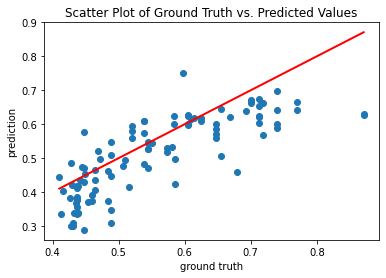

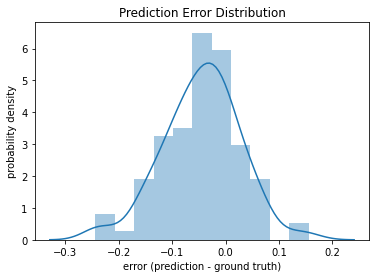

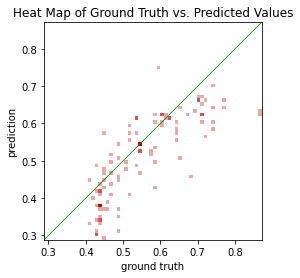

Demonstrating plotting capabilities


In [16]:
eval_stats.plotScatterGroundTruthPredictions()
eval_stats.plotErrorDistribution()
eval_stats.plotHeatmapGroundTruthPredictions()
plt.show()
print("Demonstrating plotting capabilities")

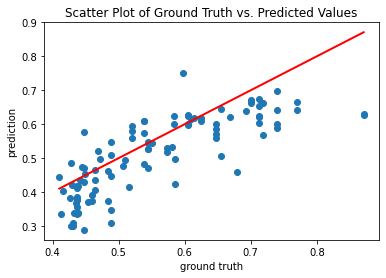

In [17]:
eval_stats.plotScatterGroundTruthPredictions()
plt.show()

## Things we left out in this intro

 - Already implemented models and feature generators
 - Caching (this is actually one of the central features)
 - Support for ensembling and parallelization
 - The local search and hyperopt modules, including grid-search, simulated-annealing and other stuff
 - kNN and clustering implementations
